<a href="https://colab.research.google.com/github/sanjay033/Walmart-sales-forecasting/blob/master/Walmart_final_draft_all_model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Authorization

In [ ]:
from google.colab import files
from google.colab import drive as drive_colab
from google.colab import auth

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/gdrive')

root_path = 'gdrive/My Drive/Colab Notebooks/'

# Authenticate user
## You must go to the link and copy access code
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Load all the required files
file_id = '1q34L52TjwlT7HvkKe8fc6mvLtGAzNcmZ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('calendar.csv')

file_id = '1F3VqpEVWoHg_8pD5FZdYmXDkxCrb09e-'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('sell_prices.csv')

file_id = '1QI9087hfvu3ugdAhc0nskiPW8g3VhdqG'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('sales_train_validation.csv')

file_id = '1A1XwNSvEtDCw4hz4FudlaqdTIbsKfGI8'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('sales_train_evaluation.csv')

file_id = '1gfeQbNefEImnJLxhPl9BqHovfbdX0aG6'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('sample_submission.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Required Libraries

## Loading GPU

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize


import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1c14d7d93471b65ac01e98f948812935309ff589e125a6bf2b3966c7f27a030f
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 637.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
torch.backends.cudnn.enabled
!nvidia-smi
!python --version

Wed Jul 22 14:06:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    32W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Loading relevant libraries

In [ ]:
# Importing libraries that will be used in this project
import pandas as pd
import numpy as np

from itertools import product
from multiprocessing import Pool
from scipy.stats import kurtosis, skew
from scipy.optimize import minimize
import scipy.stats as scs
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

# Stats
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import datetime
from dateutil.relativedelta import relativedelta
import time
import gc
import os
from tqdm import tqdm_notebook

# Ignore warnings
import warnings
warnings.filterwarnings (action = "ignore")

# Set some options in Jupyter to display datasets
pd.set_option ('display.max_columns', 200)
pd.set_option ('display.max_rows', 200)


# Importing sklearn libraries
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression

# lib of machine learning templates
import xgboost as xgb
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Reducing Memory

In [ ]:
# Function for reducing the used memory
def reduce_mem_usage (df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage (). sum () / 1024 ** 2
    for col in df.columns:
        col_type = df [col] .dtypes
        if col_type in numerics:
            c_min = df [col] .min ()
            c_max = df [col] .max ()
            if str (col_type) [: 3] == 'int':
                if c_min> np.iinfo (np.int8) .min and c_max <np.iinfo (np.int8) .max:
                    df [col] = df [col] .astype (np.int8)
                elif c_min> np.iinfo (np.int16) .min and c_max <np.iinfo (np.int16) .max:
                    df [col] = df [col] .astype (np.int16)
                elif c_min> np.iinfo (np.int32) .min and c_max <np.iinfo (np.int32) .max:
                    df [col] = df [col] .astype (np.int32)
                elif c_min> np.iinfo (np.int64) .min and c_max <np.iinfo (np.int64) .max:
                    df [col] = df [col] .astype (np.int64)
            else:
                if c_min> np.finfo (np.float16) .min and c_max <np.finfo (np.float16) .max:
                    df [col] = df [col] .astype (np.float16)
                elif c_min> np.finfo (np.float32) .min and c_max <np.finfo (np.float32) .max:
                    df [col] = df [col] .astype (np.float32)
                else:
                    df [col] = df [col] .astype (np.float64)
    end_mem = df.memory_usage (). sum () / 1024 ** 2
    if verbose: print ('Mem. usage decreased to {: 5.2f} Mb ({: .1f}% reduction)'. format (end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Load Data

In [ ]:
calendar_df  = pd.read_csv('calendar.csv')
calendar = reduce_mem_usage (calendar_df)
print(("calendar dataset has {} columns and {} rows").format(calendar.shape[0],calendar.shape[1]))


sell_prices_df = pd.read_csv('sell_prices.csv')
sell_prices = reduce_mem_usage (sell_prices_df)
print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))

sales_train_validation_df = pd.read_csv('sales_train_validation.csv')
sales_train_validation = reduce_mem_usage (sales_train_validation_df)
print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))

submission = pd.read_csv('sample_submission.csv')
submission = reduce_mem_usage (submission)

Mem. usage decreased to  0.12 Mb ( 41.9% reduction)
calendar dataset has 1969 columns and 14 rows
Mem. usage decreased to  130.48 Mb ( 37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  95.00 Mb ( 78.7% reduction)
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to  2.09 Mb ( 84.5% reduction)


# Exploratory Data Analysis

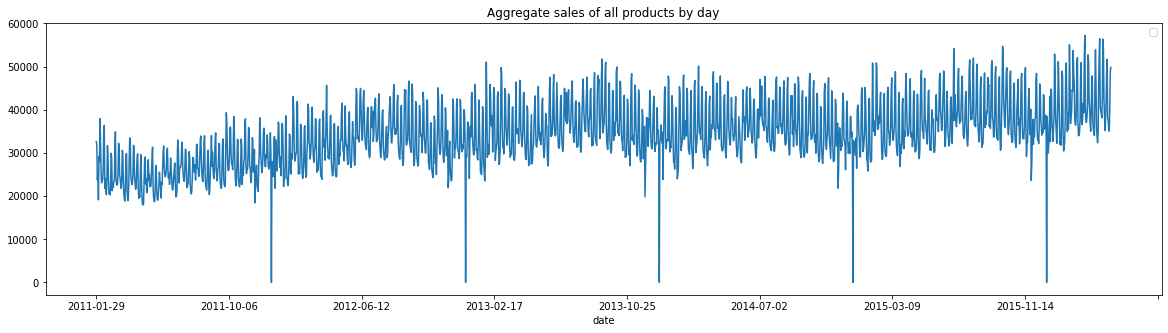

In [ ]:
d_cols = [c for c in sales_train_validation.columns if 'd_' in c] # sales data columns

aggregate_sales = sales_train_validation[d_cols].sum(axis=0).reset_index()

aggregate_sales.columns = ['d','sales']

all_data_merged = aggregate_sales.merge(calendar, how='left', validate='1:1')

y = all_data_merged.set_index('date')['sales']

y.plot(figsize=(20, 5),title='Aggregate sales of all products by day')

plt.legend('')

plt.show()

In [ ]:
past_sales = sales_train_validation.set_index('id')[d_cols] \
    .T \
    .merge(calendar.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')


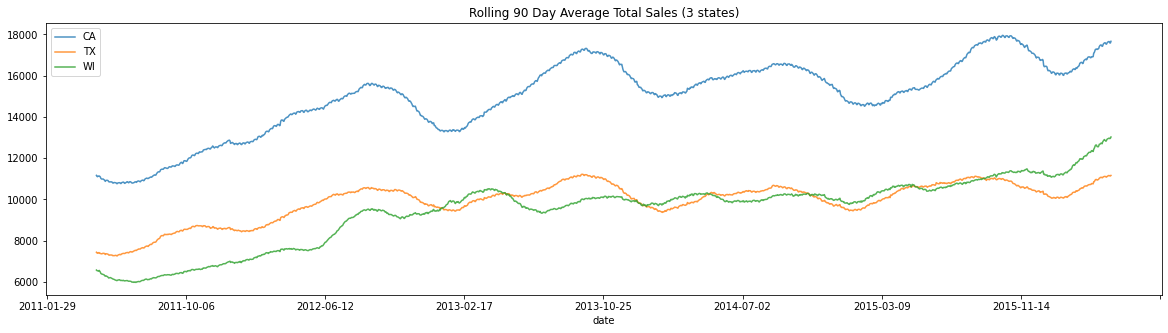

In [ ]:
state_list = sales_train_validation['state_id'].unique()

for s in state_list:
    state_items = [c for c in past_sales.columns if s in c]

    past_sales[state_items].sum(axis=1).rolling(90).mean().plot(figsize=(20, 5),
              alpha=0.8, title='Rolling 90 Day Average Total Sales (3 states)')

plt.legend(state_list)

plt.show()

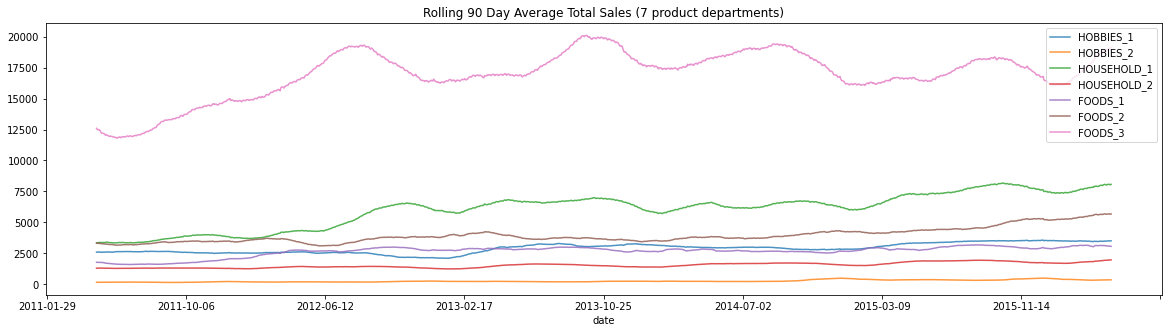

In [ ]:
dept_list = sales_train_validation['dept_id'].unique()

for s in dept_list:
    department_items = [c for c in past_sales.columns if s in c]

    past_sales[department_items].sum(axis=1).rolling(90).mean().plot(figsize=(20, 5),
              alpha=0.8, title='Rolling 90 Day Average Total Sales (7 product departments)')

plt.legend(dept_list)

plt.show()

# Merging Data

In [ ]:
# Function to merge datasets returning only one dataframe
def reshape_and_merge (calendar, sell_prices, sales_train_validation, submission, nrows=55000000, merge = False):
    
    # reshaping sales data using melt
    sales_train_validation = pd.melt (sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print ('Melted sales train validation has {} rows and {} columns'.format (sales_train_validation.shape [0], sales_train_validation.shape [1]))
    sales_trian_validation = reduce_mem_usage (sales_train_validation)
    
    # preparing test and validation records
    test_rows = [row for row in submission ['id'] if 'validation' in row]
    val_rows = [row for row in submission ['id'] if 'evaluation' in row]
    
    test = submission [submission ['id']. isin (test_rows)]
    val = submission [submission ['id']. isin (val_rows)]
    
    # renaming the columns
    test.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921',
                    'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930',
                    'd_1931', 'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
                    'd_1940', 'd_1941']
    val.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949',
                   'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958',
                   'd_1959', 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967',
                   'd_1968', 'd_1969']
    
    # getting only product data and removing duplicate records
    product = sales_train_validation [['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]. drop_duplicates ()
    
    # merge with the product table
    test = test.merge (product, how = 'left', on = 'id')
    val = val.merge (product, how = 'left', on = 'id')
    
    # reshaping test and validation data
    test = pd.melt (test, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    val = pd.melt (val, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    # creating a new column to define training, test and validation data
    sales_train_validation ['part'] = 'train'
    test ['part'] = 'test'
    val ['part'] = 'val'
    
    # creating a single dataset with the addition of all training, validation and test records
    data = pd.concat ([sales_train_validation, test, val], axis = 0)
    
    # removing previous datasets
    del sales_train_validation, test, val
    
    # selecting only a few records for training
    data = data.loc [nrows:]
    
    # removing validation data
    data = data [data ['part']!= 'val']
    
    # performing the merge with calendar and price
    if merge:
        data = pd.merge (data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop (['d', 'day', 'weekday'], inplace = True, axis = 1)
        data = data.merge (sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print ('Final dataset for training has {} rows and {} columns'.format (data.shape [0], data.shape [1]))
    else:
        pass
    
    return data



def transform(data):
    
    # realizando tratamento em valores missing nas features categoricas
    nan_features_cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features_cat:
        data[feature].fillna('unknown', inplace = True)
    
    # realizando tratamento em valores missing na feature sell_price
    data['sell_price'].fillna(0, inplace = True)
        
    # transformando features categorias em numericas para realizar as previsoes
    encoder = preprocessing.LabelEncoder()
    data['id_encode'] = encoder.fit_transform(data['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 
           'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [ ]:
%%time


# Reshaping and merging datasets
data = reshape_and_merge (calendar, sell_prices, sales_train_validation, submission,nrows=45000000, merge = True)

# Calling up the data transformation functions
data = transform (data)

# Viewing the final dataset header
data.head ()

# Clearing data from memory
gc.collect ()

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to  3226.27 Mb ( 0.0% reduction)
Final dataset for training has 14181090 rows and 21 columns
CPU times: user 2min 5s, sys: 7.78 s, total: 2min 13s
Wall time: 2min 13s


# Time Series in Python

In [ ]:
df_1 = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_WI_2_validation') & (data ['demand']> 0) & (data [ 'demand'] <= 15)]
df_1 = df_1 [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]
df_1 = df_1.set_index ('date')

df_2 = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_CA_2_validation') & (data ['demand']> 0) & (data [ 'demand'] <= 15)]
df_2 = df_2 [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]
df_2 = df_2.set_index ('date')

df_3 = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_TX_2_validation') & (data ['demand']> 0) & (data [ 'demand'] <= 15)]
df_3 = df_3 [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]
df_3 = df_3.set_index ('date')


In [ ]:
df_1.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2015-02-12,7,2,0,8,2,30,4,1,3.980469
2015-02-13,3,2,0,8,2,30,4,0,3.980469
2015-02-14,6,2,0,8,2,28,0,1,3.980469
2015-02-15,6,2,0,8,2,30,4,1,3.980469
2015-02-16,7,2,0,8,2,22,1,0,3.980469


In [ ]:
df_2.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2015-02-13,2,2,0,1,0,30,4,0,3.980469
2015-02-14,1,2,0,1,0,28,0,1,3.980469
2015-02-15,9,2,0,1,0,30,4,1,3.980469
2015-02-18,1,2,0,1,0,11,2,0,3.980469
2015-02-19,1,2,0,1,0,30,4,0,3.980469


In [ ]:
df_3.head()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2015-02-13,7,2,0,5,1,30,4,0,3.980469
2015-02-14,8,2,0,5,1,28,0,1,3.980469
2015-02-15,5,2,0,5,1,30,4,1,3.980469
2015-02-16,4,2,0,5,1,22,1,0,3.980469
2015-02-17,9,2,0,5,1,30,4,0,3.980469


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

## SARIMAX

In [ ]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 28 # season length is still 28

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [ ]:
def optimizeSARIMA(parameters_list, d, D, s, df):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df['demand'], 
                                            order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
result_table_1 = optimizeSARIMA(parameters_list, d, D, s, df_1)

In [ ]:
result_table_2 = optimizeSARIMA(parameters_list, d, D, s, df_2)

In [ ]:
result_table_3 = optimizeSARIMA(parameters_list, d, D, s, df_3)

In [ ]:
result_table_1.head()

,parameters,aic
0,"(2, 3, 0, 1)",1515.528069
1,"(3, 4, 0, 1)",1517.114745
2,"(2, 3, 1, 1)",1517.529404
3,"(2, 4, 0, 1)",1517.551408
4,"(3, 4, 1, 1)",1518.842693


In [ ]:
result_table_2.head()

,parameters,aic
0,"(2, 3, 0, 1)",1369.028401
1,"(4, 3, 0, 1)",1369.917111
2,"(2, 3, 1, 1)",1370.491349
3,"(3, 3, 1, 1)",1372.329919
4,"(4, 4, 0, 1)",1373.396469


In [ ]:
result_table_3.head()

,parameters,aic
0,"(2, 2, 0, 1)",1193.861440
1,"(2, 3, 0, 1)",1193.889895
2,"(2, 2, 1, 1)",1194.675560
3,"(4, 4, 0, 1)",1195.046446
4,"(2, 4, 0, 1)",1195.050220


In [ ]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table_1.parameters[0]

best_model_1=sm.tsa.statespace.SARIMAX(df_1['demand'],order=(p, d, q),seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model_1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                  335
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 28)   Log Likelihood                -750.764
Date:                            Tue, 21 Jul 2020   AIC                           1515.528
Time:                                    02:16:08   BIC                           1541.593
Sample:                                         0   HQIC                          1525.952
                                            - 335                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1321      0.026     43.397      0.000       1.081       1.183
ar.L2         -0.9699      0.026   

In [ ]:
p, q, P, Q = result_table_2.parameters[0]

best_model_2=sm.tsa.statespace.SARIMAX(df_2['demand'],order=(p, d, q),seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model_2.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                  306
Model:             SARIMAX(2, 1, 3)x(0, 1, 1, 28)   Log Likelihood                -677.514
Date:                            Tue, 21 Jul 2020   AIC                           1369.028
Time:                                    02:16:44   BIC                           1394.397
Sample:                                         0   HQIC                          1379.207
                                            - 306                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0955      0.082     13.326      0.000       0.934       1.257
ar.L2         -0.8274      0.086   

In [ ]:
p, q, P, Q = result_table_3.parameters[0]

best_model_3=sm.tsa.statespace.SARIMAX(df_3['demand'],order=(p, d, q),seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model_3.summary())

                                 Statespace Model Results                                 
Dep. Variable:                             demand   No. Observations:                  290
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 28)   Log Likelihood                -590.931
Date:                            Tue, 21 Jul 2020   AIC                           1193.861
Time:                                    02:16:58   BIC                           1215.249
Sample:                                         0   HQIC                          1202.458
                                            - 290                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3047      0.958      0.318      0.751      -1.574       2.183
ar.L2         -0.0946      0.152   

In [ ]:
def errorSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    dfCopy = series.copy()
    
    dfCopy['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    dfCopy['arima_model'][:s+d] = np.NaN    
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = dfCopy.shape[0], end = dfCopy.shape[0]+n_steps)
    forecast = dfCopy['arima_model'].append(forecast)

    # calculate error, again having shifted on s+d steps from the beginning
    error = rmse(dfCopy['demand'][s+d:], dfCopy['arima_model'][s+d:])
    return ("RMSE: {0:.2f}".format(error))



In [ ]:
errorSARIMA(df_1, best_model_1, 28)

'RMSE: 2.88'

In [ ]:
errorSARIMA(df_2, best_model_2, 28)

'RMSE: 2.79'

In [ ]:
errorSARIMA(df_3, best_model_3, 28)

'RMSE: 2.37'

In [ ]:
# Select training and validation data only for analysis
# Selecting only 1 item for testing: FOODS_3_634_WI_2
df = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_WI_2_validation') & (data ['demand']> 0) & (data [ 'demand'] <= 15)]

# Selecting only a few columns for analysis and training
df = df [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]

# Transforming the date as index
df = df.set_index ('date')

# Viewing the dataset result
df.head ()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price
date,,,,,,,,,
2015-02-12,7,2,0,8,2,30,4,1,3.980469
2015-02-13,3,2,0,8,2,30,4,0,3.980469
2015-02-14,6,2,0,8,2,28,0,1,3.980469
2015-02-15,6,2,0,8,2,30,4,1,3.980469
2015-02-16,7,2,0,8,2,22,1,0,3.980469


## Feature engineering

In [ ]:
new_df = data [(data ['date'] <= '2016-04-24') & (data ['demand']> 0)]
new_df = new_df [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]
new_df = new_df.set_index ('date')

In [ ]:
df = data [(data ['date'] <= '2016-04-24') & (data ['demand']> 0)]
df = df [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]
df = df.set_index ('date')

In [ ]:
for i in range(7, 29):
    new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [ ]:
y = new_df.dropna()['demand']
X = new_df.dropna().drop(['demand'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [ ]:
new_df.index = pd.to_datetime(new_df.index)
new_df["day"] = new_df.index.day
new_df["weekday"] = new_df.index.weekday
new_df['is_weekend'] = new_df.weekday.isin([5,6])*1
new_df.tail()

,demand,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,snap_WI,sell_price,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,day,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-04-24,2,2,0,9,2,30,4,0,1.980469,1.0,1.0,2.0,2.0,10.0,2.0,1.0,1.0,1.0,2.0,6.0,6.0,4.0,1.0,16.0,9.0,1.0,1.0,1.0,1.0,1.0,11.0,24,6,1
2016-04-24,1,2,0,9,2,30,4,0,1.980469,1.0,1.0,1.0,2.0,2.0,10.0,2.0,1.0,1.0,1.0,2.0,6.0,6.0,4.0,1.0,16.0,9.0,1.0,1.0,1.0,1.0,1.0,24,6,1
2016-04-24,1,2,0,9,2,30,4,0,3.980469,28.0,1.0,1.0,1.0,2.0,2.0,10.0,2.0,1.0,1.0,1.0,2.0,6.0,6.0,4.0,1.0,16.0,9.0,1.0,1.0,1.0,1.0,24,6,1
2016-04-24,1,2,0,9,2,30,4,0,2.980469,3.0,28.0,1.0,1.0,1.0,2.0,2.0,10.0,2.0,1.0,1.0,1.0,2.0,6.0,6.0,4.0,1.0,16.0,9.0,1.0,1.0,1.0,24,6,1
2016-04-24,3,2,0,9,2,30,4,0,1.280273,4.0,3.0,28.0,1.0,1.0,1.0,2.0,2.0,10.0,2.0,1.0,1.0,1.0,2.0,6.0,6.0,4.0,1.0,16.0,9.0,1.0,1.0,24,6,1


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
X = new_df.dropna().drop(['demand'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
X_test_scaled = scaler.transform(X_test)

In [ ]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    new_df = df.copy()

    # lags of series
    for i in range(7, 29):
        new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

    # datetime features
    new_df.index = pd.to_datetime(new_df.index)
    new_df["day"] = new_df.index.day
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(new_df.dropna())*(1-test_size))
        new_df['weekday_average'] = list(map(code_mean(new_df[:test_index], 'weekday', "demand").get, new_df['weekday']))
        new_df["day_average"] = list(map(code_mean(new_df[:test_index], 'day', "demand").get, new_df['day']))

        # frop encoded variables 
        new_df.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = new_df.dropna()['demand']
    X = new_df.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test =\
prepareData(df, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)

In [ ]:
X_test_scaled = scaler.transform(X_test)

# XGBoost

In [ ]:
from xgboost import XGBRegressor 
xgb = XGBRegressor()

In [ ]:
model_xgb = xgb.fit(X_train_scaled, y_train)

[14:13:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:13:44] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

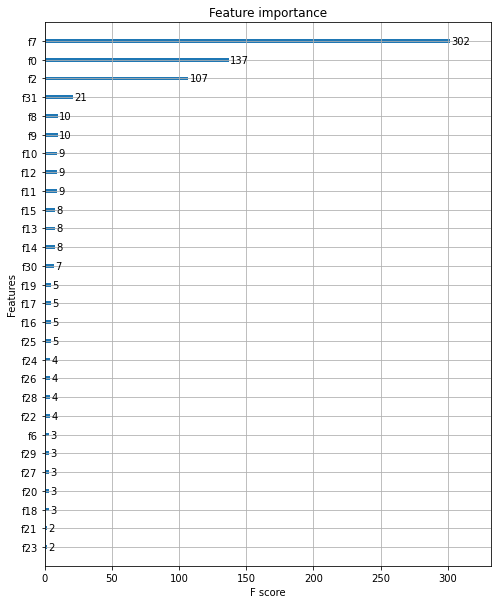

In [ ]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
ax = plot_importance(model_xgb)
fig = ax.figure
fig.set_size_inches(8, 10)
plt.show()


In [ ]:
def ModelResults(model, X_train, X_test,y_test):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
   
    error = rmse(y_test, prediction)
    return error 

In [ ]:
ModelResults(xgb, X_train=X_train_scaled, X_test=X_test_scaled)

4.572642

In [ ]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmse(y_test, prediction)
    return error
  
  

NameError: ignored

[03:43:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:47:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:51:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:58:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


4.572642

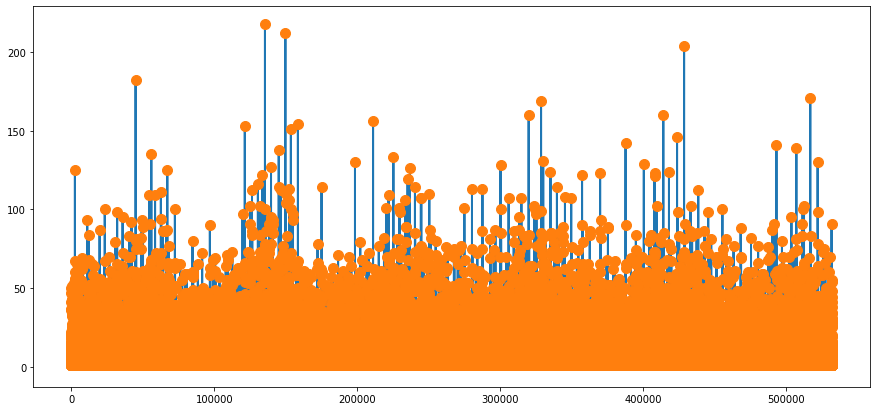

In [ ]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)

# Light GBM

In [ ]:
from lightgbm import LGBMRegressor 

lgb = LGBMRegressor()

In [ ]:
%%time

model_lgb = lgb.fit(X_train_scaled, y_train)

CPU times: user 1min 21s, sys: 170 ms, total: 1min 21s
Wall time: 1min 21s


In [ ]:
ModelResults(lgb, X_train=X_train_scaled, X_test=X_test_scaled)

4.358830636466478

# Forecasting on different products

In [ ]:
df_1 = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_2_360_WI_2_validation') & (data ['demand']> 0) ]
df_1 = df_1 [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]
df_1 = df_1.set_index ('date')

df_2 = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_2_197_CA_3_validation') & (data ['demand']> 0) ]
df_2 = df_2 [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]
df_2 = df_2.set_index ('date')

df_3 = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_2_360_TX_3_validation') & (data ['demand']> 0) ]
df_3 = df_3 [['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]
df_3 = df_3.set_index ('date')


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    new_df = series.copy()

    # lags of series
    for i in range(7, 29):
        new_df["lag_{}".format(i)] = new_df['demand'].shift(i)

    # datetime features
    new_df.index = pd.to_datetime(new_df.index)
    new_df["day"] = new_df.index.day
    new_df["weekday"] = new_df.index.weekday
    new_df['is_weekend'] = new_df.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(new_df.dropna())*(1-test_size))
        new_df['weekday_average'] = list(map(code_mean(new_df[:test_index], 'weekday', "demand").get, new_df['weekday']))
        new_df["day_average"] = list(map(code_mean(new_df[:test_index], 'day', "demand").get, new_df['day']))

        # frop encoded variables 
        new_df.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = new_df.dropna()['demand']
    X = new_df.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [ ]:
def plotModelResults(model, X_train, X_test,y_train, y_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmse(y_test, prediction)
    plt.title("RMSE: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 =prepareData(df_1, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_test_scaled_1 = scaler.transform(X_test_1)

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 =prepareData(df_2, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

X_train_scaled_2 = scaler.fit_transform(X_train_2)
X_test_scaled_2 = scaler.transform(X_test_2)

In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 =prepareData(df_3, lag_start=1, lag_end=29, test_size=0.1, target_encoding=False)

X_train_scaled_3 = scaler.fit_transform(X_train_3)
X_test_scaled_3 = scaler.transform(X_test_3)

## XGB

In [ ]:
xgb.fit(X_train_scaled_1, y_train_1)

[08:30:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[08:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


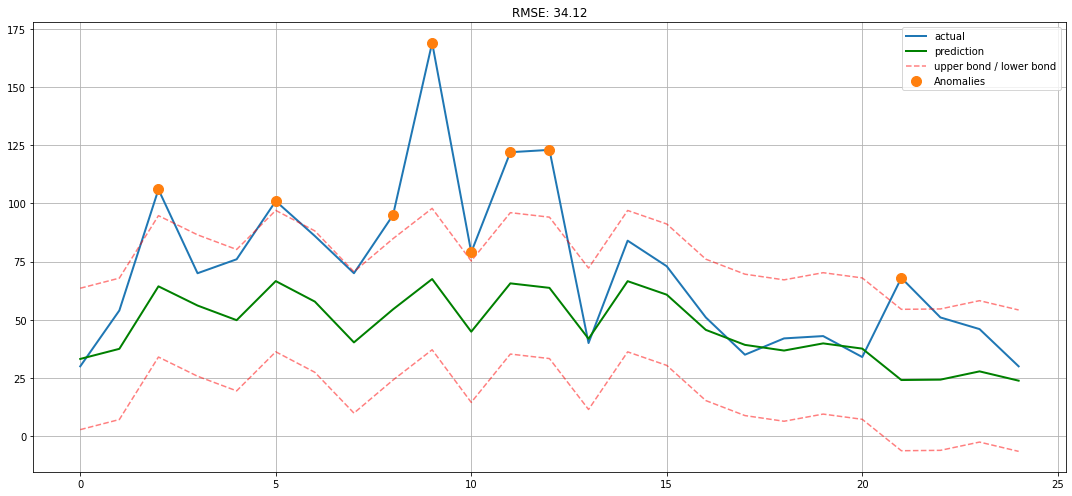

In [ ]:
plotModelResults(xgb, X_train=X_train_scaled_1, X_test=X_test_scaled_1,y_train= y_train_1, y_test = y_test_1, plot_intervals=True, plot_anomalies=True)

In [ ]:
ModelResults(xgb, X_train=X_train_scaled_1, X_test=X_test_scaled_1, y_test= y_test_1)

34.122368

In [ ]:
xgb.fit(X_train_scaled_2, y_train_2)

[08:30:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[08:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:30:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


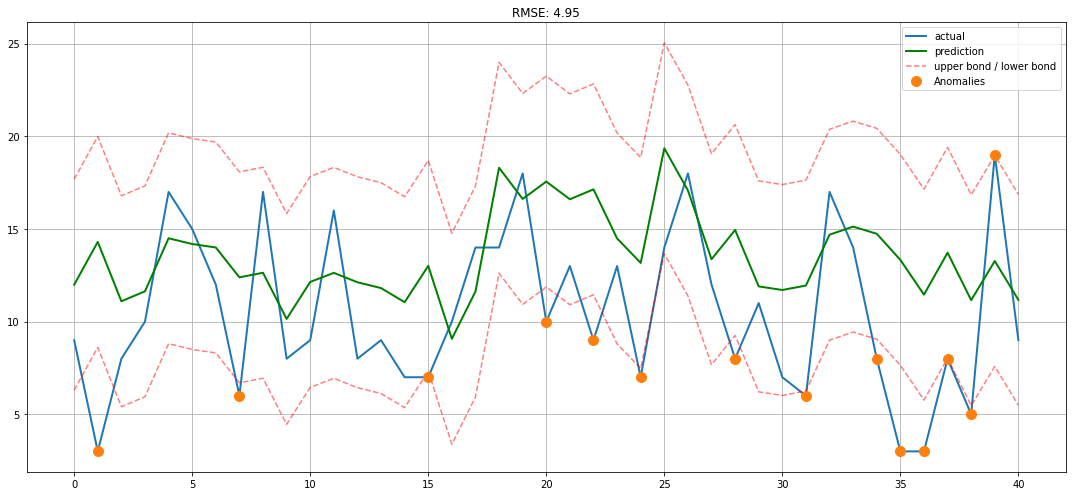

In [ ]:
plotModelResults(xgb, X_train=X_train_scaled_2, X_test=X_test_scaled_2,y_train= y_train_2, y_test = y_test_2, plot_intervals=True, plot_anomalies=True)

In [ ]:
ModelResults(xgb, X_train=X_train_scaled_2, X_test=X_test_scaled_2, y_test= y_test_2)

4.946176

In [ ]:
xgb.fit(X_train_scaled_3, y_train_3)

[08:31:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

[08:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


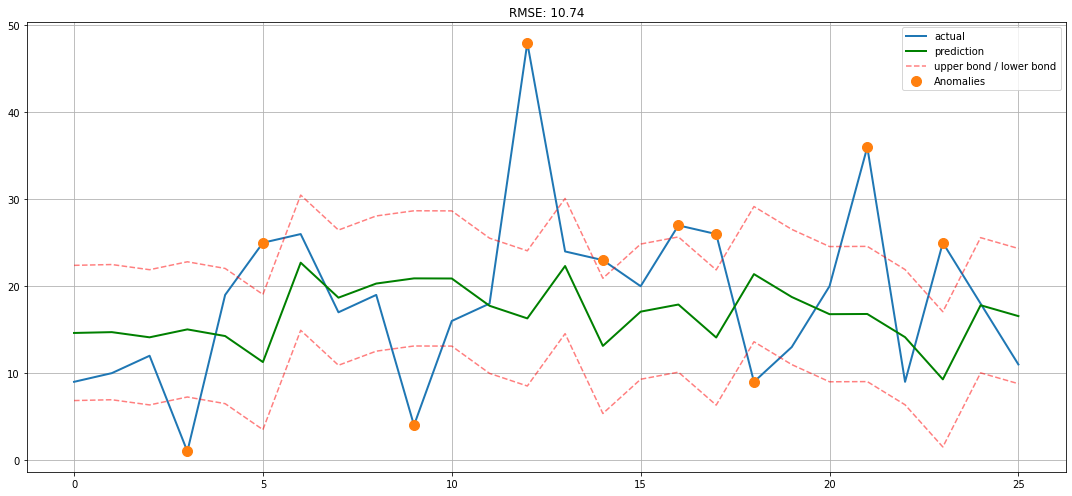

In [ ]:
plotModelResults(xgb, X_train=X_train_scaled_3, X_test=X_test_scaled_3,y_train= y_train_3, y_test = y_test_3, plot_intervals=True, plot_anomalies=True)

In [ ]:
ModelResults(xgb, X_train=X_train_scaled_3, X_test=X_test_scaled_3, y_test= y_test_3)

10.740171

In [ ]:
lgb.fit(X_train_scaled_1, y_train_1)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
ModelResults(lgb, X_train=X_train_scaled_1, X_test=X_test_scaled_1, y_test= y_test_1)

38.96978611456272

In [ ]:
lgb.fit(X_train_scaled_2, y_train_2)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
ModelResults(lgb, X_train=X_train_scaled_2, X_test=X_test_scaled_2, y_test= y_test_2)

5.645999428540504

In [ ]:
lgb.fit(X_train_scaled_3, y_train_3)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
ModelResults(lgb, X_train=X_train_scaled_3, X_test=X_test_scaled_3, y_test= y_test_3)

11.323302682476124